# This notebook is for the Fair-Shapely experiment

In [1]:
%reload_ext autoreload
%autoreload 2

### 1. Import libraries

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

### 2. Import dataset

In [3]:
from src.data.unified_dataloader import load_dataset

a, processed_census_income_kdd = load_dataset('census_income_kdd')

age                                           0
workclass                                     0
industry_code                                 0
occupation_code                               0
education                                     0
wage_per_hour                                 0
enrolled_in_edu_inst_last_wk                  0
marital_status                                0
major_industry_code                           0
major_occupation_code                         0
race                                          0
hispanic_origin                               0
sex                                           0
member_of_a_labour_union                      0
reason_for_unemployment                       0
employment_status                             0
capital_gains                                 0
capital_losses                                0
dividend_from_stocks                          0
tax_filler_status                             0
region_of_previous_residence            

In [4]:
processed_census_income_kdd.head(3)

,age,wage_per_hour,capital_gains,capital_losses,dividend_from_stocks,instance_weight,num_persons_worked_for_employer,weeks_worked_in_year,sex,workclass_ Federal government,...,own_business_or_self_employed_2,fill_inc_questionnaire_for_veteran's_admin_ No,fill_inc_questionnaire_for_veteran's_admin_ Not in universe,fill_inc_questionnaire_for_veteran's_admin_ Yes,veterans_benefits_0,veterans_benefits_1,veterans_benefits_2,year_94,year_95,class
0,1.706939,-0.203989,-0.093502,-0.138177,-0.10222,-0.043817,-0.843184,-0.970621,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1
1,1.030500,-0.203989,-0.093502,-0.138177,-0.10222,-0.691534,-0.421771,1.158280,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1
2,-0.773339,-0.203989,-0.093502,-0.138177,-0.10222,-0.753246,-0.843184,-0.970621,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1


### 3. Split label/unlabel data, split train/test data.

In [5]:
'''census income kdd dataset'''
sampled_data = processed_census_income_kdd.sample(frac=0.15, random_state=42)
df = sampled_data.copy()
X = df.drop('class', axis=1)
y = df['class']



# into 70% training and 30% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=25) 
print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')

X_train shape: (30039, 505)
X_test shape: (12874, 505)


### 4. Train the original model

In [6]:
model = XGBClassifier()  # 可以替换为 RandomForestClassifier() 等其他模型
model.fit(X_train,y_train)

# 预测和评估
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.9366941121640516


In [7]:
X_train['sex'].value_counts()

sex
0.0    15489
1.0    14550
Name: count, dtype: int64

In [8]:
'''把X_train分成majority和minority两个部分'''

male_condition = X_train['sex'] == 0
X_train_majority = X_train[male_condition]
y_train_majority = y_train[male_condition]

female_condition = X_train['sex'] == 1
X_train_minority = X_train[female_condition]
y_train_minority = y_train[female_condition]

### 5. Evaluate the performance of original model

In [9]:
from src.attribution.oracle_metric import perturb_numpy_ver
from src.attribution import FairnessExplainer
sen_att_name = ["sex"]
sen_att = [X_train.columns.get_loc(name) for name in sen_att_name]
priv_val = [1]
unpriv_dict = [list(set(X_train.values[:, sa])) for sa in sen_att]
for sa_list, pv in zip(unpriv_dict, priv_val):
    sa_list.remove(pv)
# print(f'sen_att_name:{sen_att_name}')
# print(f'sen_att:{sen_att}') # index of sensitive attribute
# print(f'priv_val:{priv_val}') # privileged value
# print(f'unpriv_dict:{unpriv_dict}') # unprivileged value(all values in the sensitive attribute, except the privileged value)



''' 
计算DR value的函数
'''
def fairness_value_function(sen_att, priv_val, unpriv_dict, X, model):
    X_disturbed = perturb_numpy_ver(
        X=X,
        sen_att=sen_att,
        priv_val=priv_val,
        unpriv_dict=unpriv_dict,
        ratio=1.0,
    )
    fx = model.predict_proba(X)[:, 1]
    fx_q = model.predict_proba(X_disturbed)[:, 1]
    return np.mean(np.abs(fx - fx_q))
original_DR = fairness_value_function(sen_att, priv_val, unpriv_dict, X_test.values, model)
print(f'original_DR: {original_DR}')

c:\Users\ZhuLi\Anaconda3\envs\unlabel_fair\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


original_DR: 0.08531209826469421


### 5. 把female和male匹配，（或者male和female匹配），然后进行修改，重新训练

In [10]:
'''
只考虑替换shapley value > 0.1 的值
'''

'\n只考虑替换shapley value > 0.1 的值\n'

3. 将X_train_minority与X_train_replace_majority进行匹配
4. 使用fairshap,把X_train_minority作为baseline dataset，找到X_train_replace_majority中需要替换的数据
未处理前非0值的个数:68216


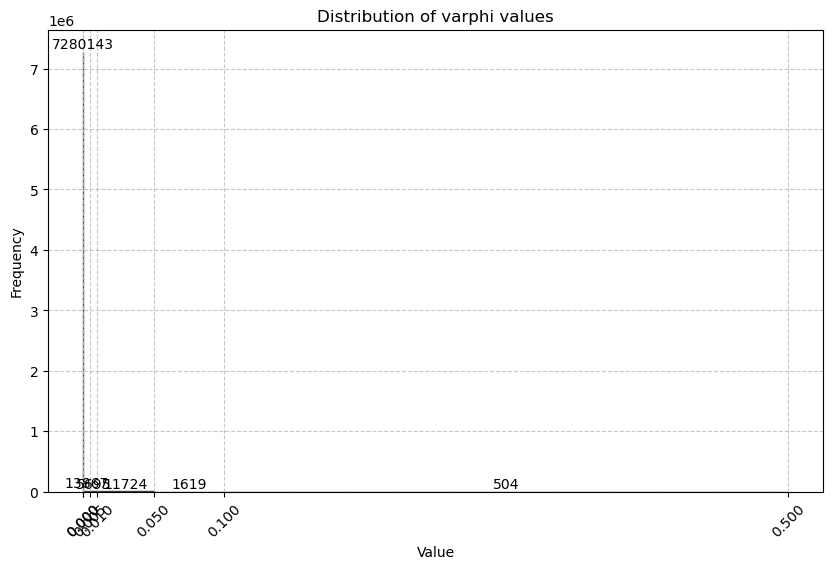

shapley value 大于0.1的值的个数:504


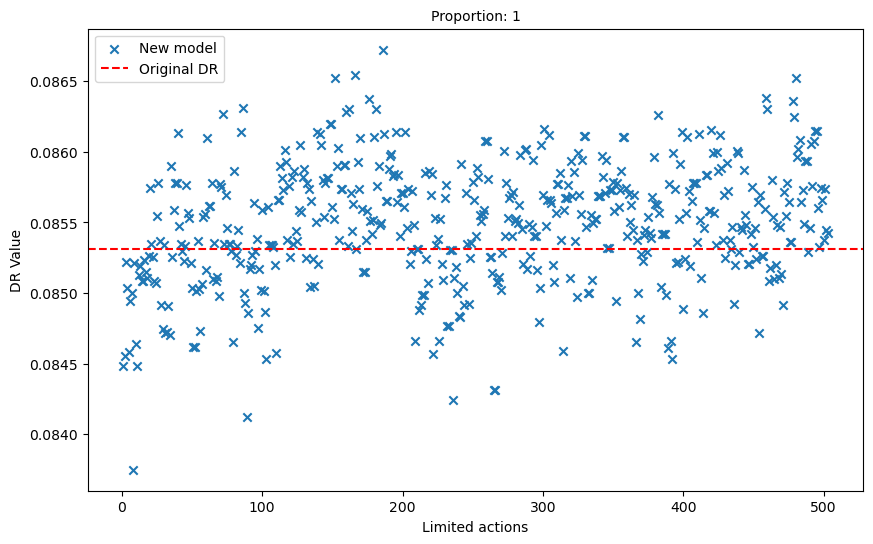

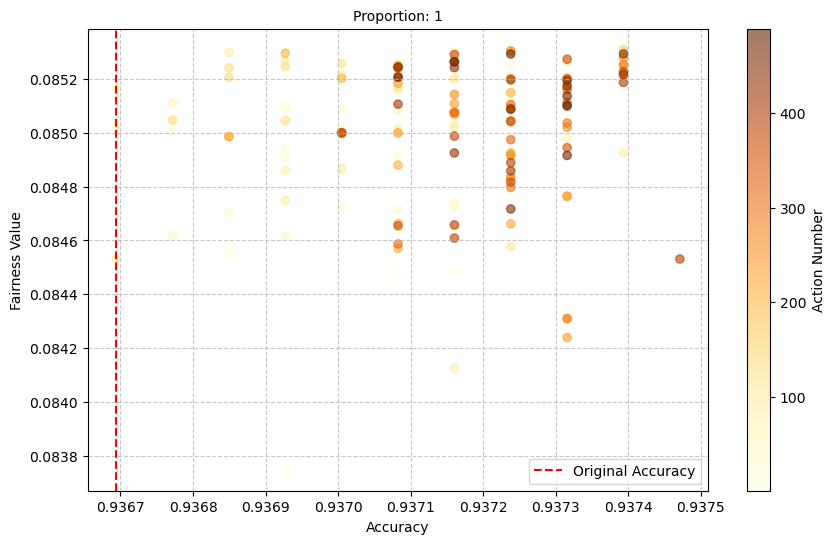

([0.084481284,
  0.08455039,
  0.08521968,
  0.08503544,
  0.08458275,
  0.08494288,
  0.08500162,
  0.083747186,
  0.08521509,
  0.084636144,
  0.08448361,
  0.08513027,
  0.08519459,
  0.08508634,
  0.08508634,
  0.08523179,
  0.08514917,
  0.085108116,
  0.08526209,
  0.08574312,
  0.085343994,
  0.08525697,
  0.085085645,
  0.08507158,
  0.08554577,
  0.085779086,
  0.08536696,
  0.08491131,
  0.08474208,
  0.08533676,
  0.084717296,
  0.08472389,
  0.08490807,
  0.08470375,
  0.0859015,
  0.085254915,
  0.0855907,
  0.08578193,
  0.08578193,
  0.08613076,
  0.08547771,
  0.085347906,
  0.08529637,
  0.085223556,
  0.08533051,
  0.08576792,
  0.08556822,
  0.085529655,
  0.085210785,
  0.0850338,
  0.08461733,
  0.08461618,
  0.0850121,
  0.085367166,
  0.085025735,
  0.08472724,
  0.08506017,
  0.0855411,
  0.08556253,
  0.08516387,
  0.0860993,
  0.085618265,
  0.085618265,
  0.08578012,
  0.08509824,
  0.08535406,
  0.08508739,
  0.08511045,
  0.08497952,
  0.085774004,
  0.0857

In [11]:
from src.experiments_approach2 import ExperimentNew

''' 改变minority group中的部分特征值'''

experiment = ExperimentNew(
                            model,
                            X_train_majority,
                            y_train_majority,
                            X_train_minority,
                            y_train_minority,
                            X_test,
                            y_test,
                            dataset_name='census_income',
                            change_group = 'minority')
experiment.run_experiment()


3. 将X_train_minority与X_train_replace_majority进行匹配
4. 使用fairshap,把X_train_replace_majority作为baseline dataset，找到X_train_minority中需要替换的数据
未处理前非0值的个数:73689


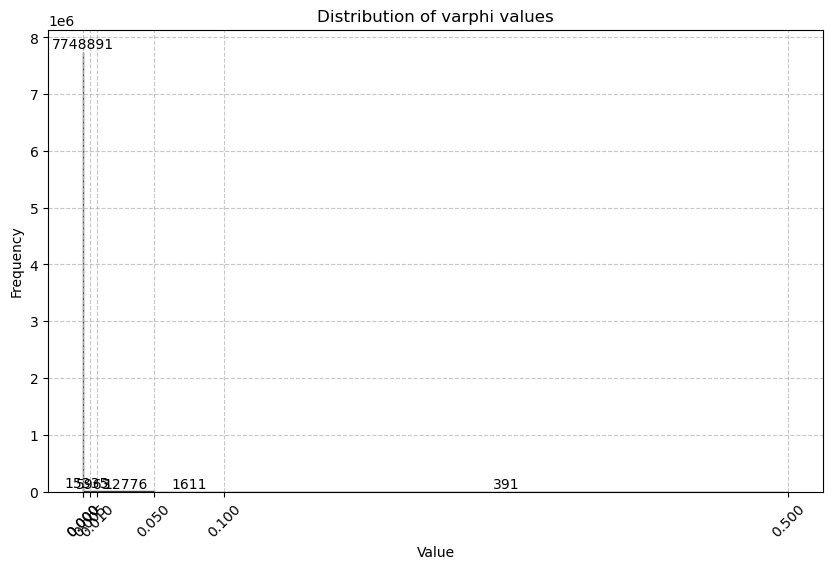

shapley value 大于0.1的值的个数:391


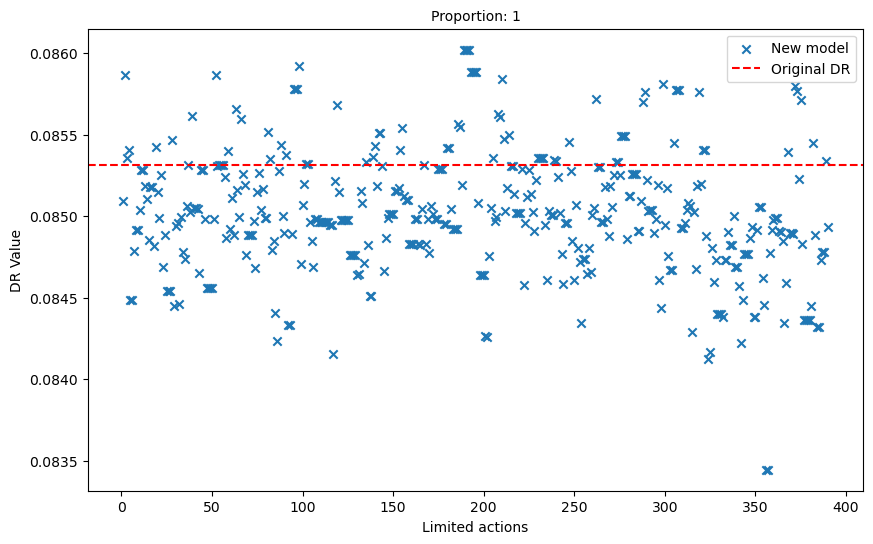

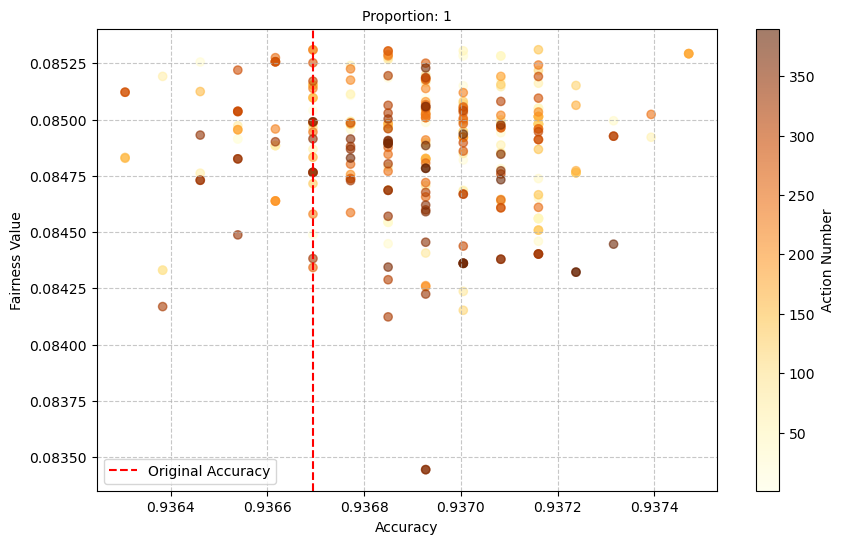

([0.08509459,
  0.085868016,
  0.0853598,
  0.085407495,
  0.08448877,
  0.08448882,
  0.084787354,
  0.08491361,
  0.08491364,
  0.08504082,
  0.08528235,
  0.08528489,
  0.085184805,
  0.08510735,
  0.08485548,
  0.08518066,
  0.08518073,
  0.08482019,
  0.08542542,
  0.085149944,
  0.084987335,
  0.085255645,
  0.08468672,
  0.08488272,
  0.08454371,
  0.084543735,
  0.084543765,
  0.08547043,
  0.08444821,
  0.084941536,
  0.08495629,
  0.08445921,
  0.0849946,
  0.08478182,
  0.08473776,
  0.08506055,
  0.08531217,
  0.08502364,
  0.085616164,
  0.08505078,
  0.08505079,
  0.08504692,
  0.08465172,
  0.08528259,
  0.08528261,
  0.084984906,
  0.08456054,
  0.08456047,
  0.08456012,
  0.08456012,
  0.084981725,
  0.085867666,
  0.085305385,
  0.08531528,
  0.08531502,
  0.08531617,
  0.085240304,
  0.084868334,
  0.08540269,
  0.08492146,
  0.08511303,
  0.08488694,
  0.08566042,
  0.08516139,
  0.084998295,
  0.085594006,
  0.085257776,
  0.08519177,
  0.084761724,
  0.08488467,
 

In [12]:
from src.experiments_approach2 import ExperimentNew

''' 改变majority group中的部分特征值'''
experiment2 = ExperimentNew(
                            model,
                            X_train_majority,
                            y_train_majority,
                            X_train_minority,
                            y_train_minority,
                            X_test,
                            y_test,
                            dataset_name='census_income',
                            change_group = 'majority')
experiment2.run_experiment()